In [1]:
import numpy as np
from solvers import ODESolve
from systems import pendulum_time_invariant, lorenz
import matplotlib.pyplot as plt
%matplotlib inline
import random

# Test ODE
x0 = np.array([1.0,1.0])
f  = pendulum_time_invariant
dt = 0.01
num_timesteps=2000
t = np.arange(start=0, stop=num_timesteps*dt, step=dt)
print(ODESolve(f, x0, t, method='rk4').shape)

(2000, 2)


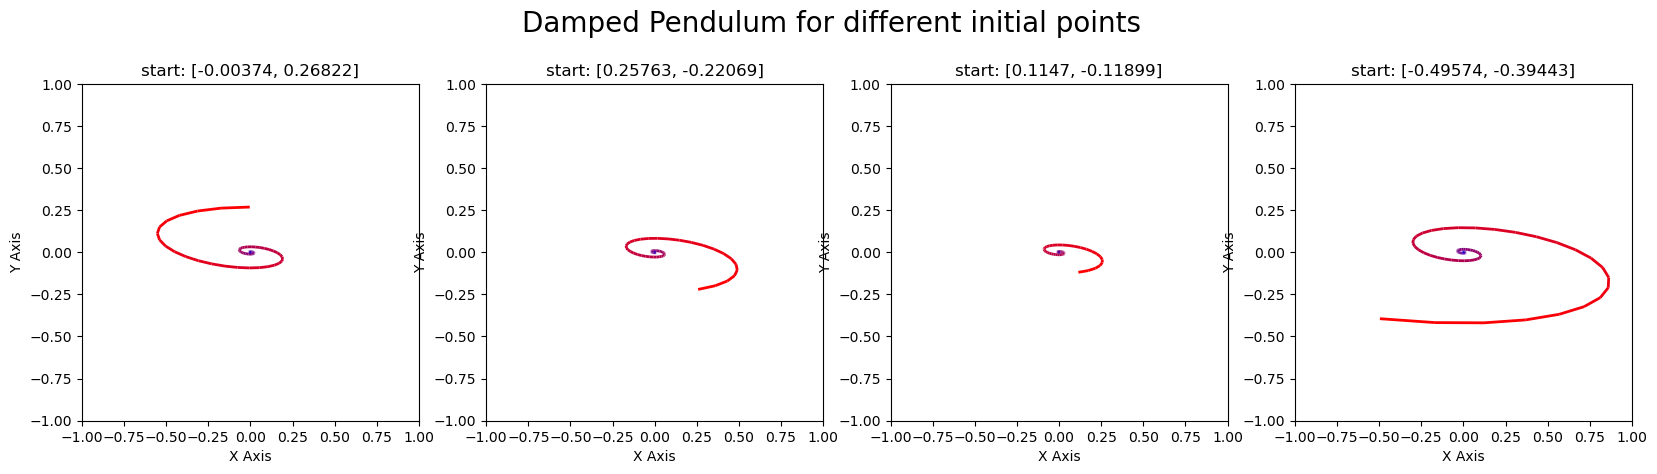

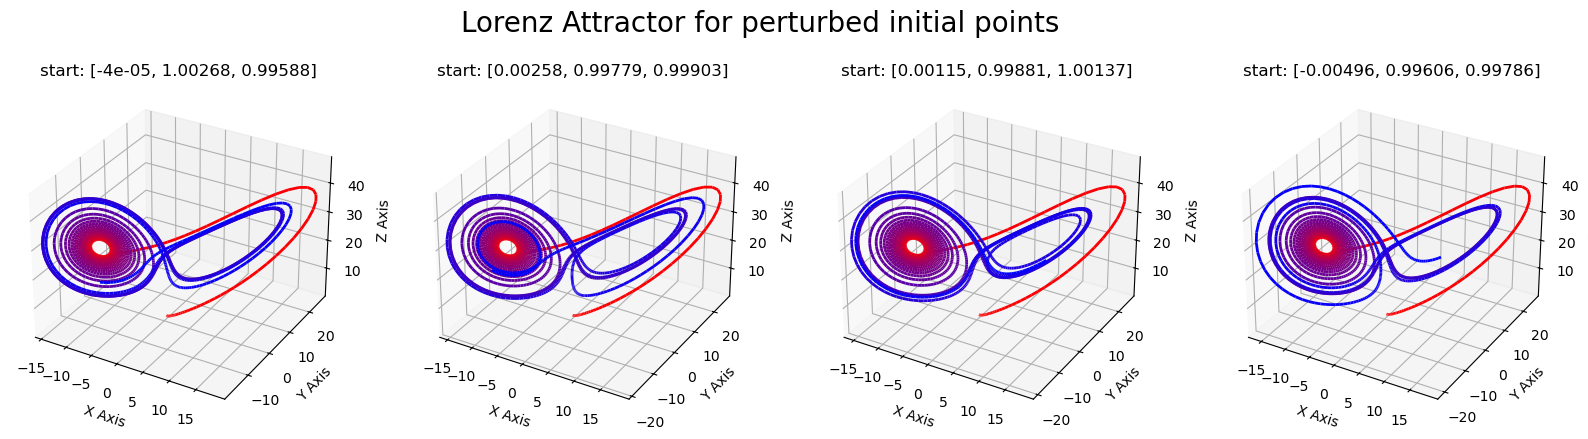

In [2]:
import torch
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

class TrajectoryDataset(torch.utils.data.Dataset):
    """
    Provides a standard configuration dataset for different physics problems + solvers 
    """
    # TODO: 
    # - pass parameters to integrator (dt, ...)
    # - pass parameters to ode (physics parameters, ...)
    def __init__(self, ode, integrator, num_samples=100, num_timesteps=5000):
        self.num_timesteps = num_timesteps
        self.num_samples = num_samples
        self.ode = ode
        self.integrator = integrator

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        
        torch.manual_seed(idx)
        
        if self.ode is pendulum_time_invariant:
            start = torch.rand(2)-0.5
            dt = 0.07
        
        elif self.ode is lorenz:
            perturbation = 1e-2
            start = torch.tensor([0,1.,1.]) + (torch.rand(3)-0.5)*perturbation
            dt = 0.01
        else:
            raise(NotImplementedError)
        
        t = np.arange(start=0, stop=self.num_timesteps*dt, step=dt)
        trajectory = ODESolve(f=self.ode, y0=start, t=t, dt=dt)
        return torch.tensor(trajectory).float()
        # return torch.tensor(self.integrator(self.ode, self.num_timesteps, start, dt)).float()

def plot_state_diagram(samples, title):
    fig = plt.figure(figsize=(20,5))
    plt.suptitle(title, fontsize=20)
    for i,sample in enumerate(samples):
        
        xy = sample[0]
        n_points = xy.shape[0]
        start_color = np.array([1, 0, 0])
        end_color = np.array([0, 0, 1])  
        colors = np.outer(np.linspace(0, 1, n_points), end_color) + np.outer(np.linspace(1, 0, n_points), start_color)
        
        if xy.shape[1] == 2:
            ax = fig.add_subplot(1, len(samples), i+1)
            points = xy.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, colors=colors, linewidth=2)
            ax.add_collection(lc)
            ax.set_xlim([-1, +1])
            ax.set_ylim([-1, +1])
            ax.set_aspect('equal')
        else:
            ax = fig.add_subplot(1, len(samples), i+1, projection='3d')
            points = xy.reshape(-1,1,3)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = Line3DCollection(segments, colors=colors, linewidth=2)
            ax.add_collection3d(lc)
            ax.set_xlim(xy[:, 0].min(), xy[:, 0].max())
            ax.set_ylim(xy[:, 1].min(), xy[:, 1].max())
            ax.set_zlim(xy[:, 2].min(), xy[:, 2].max())

        ax.set_xlabel("X Axis")
        ax.set_ylabel("Y Axis")
        if xy.shape[1] == 3:
            ax.set_zlabel('Z Axis')

        ax.set_title(f"start: {[round(x, 5) for x in xy[0].tolist()]}")

    plt.show()

dataset_pendulum = TrajectoryDataset(integrator='rk4', ode=pendulum_time_invariant, num_timesteps=100)
dataloader_pendulum = torch.utils.data.DataLoader(dataset=dataset_pendulum, batch_size=1, shuffle=False)

dataset_lorenz = TrajectoryDataset(integrator='rk4', ode=lorenz, num_timesteps=2000)
dataloader_lorenz = torch.utils.data.DataLoader(dataset=dataset_lorenz, batch_size=1, shuffle=False)

pendulum_samples = []
lorenz_samples = []
for i,(p,l) in enumerate(zip(dataloader_pendulum, dataloader_lorenz)):
    pendulum_samples.append(p)
    lorenz_samples.append(l)
    if i==3:
        break

plot_state_diagram(pendulum_samples, "Damped Pendulum for different initial points")
plot_state_diagram(lorenz_samples, "Lorenz Attractor for perturbed initial points")

In [10]:
from baselines import RNN
import torch.nn as nn
import os

def train_one_epoch(epoch_nr, model, train_dataloader, optimizer, loss_fn, run_dir, log_every=100):

    running_loss = 0.0
    model.train()

    for i, states in enumerate(train_dataloader):

        states.requires_grad_(True)
        optimizer.zero_grad()
      
        pred, _ = model(states)

        loss = loss_fn(pred,states)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_every == log_every-1:
            last_loss = running_loss/log_every

            print(f"Epoch {epoch_nr+1}, Iteration {i+1}, Training loss {last_loss}")
            plt.figure(figsize=(5,5))
            plt.plot(*(np.array(pred[0].detach()).T),label="RNN")
            plt.plot(*(np.array(states[0].detach()).T),label="GT")
            plt.legend(loc="upper left")

            filename = f"epoch_{str(epoch_nr+1).zfill(3)}_iter_{str(i+1).zfill(4)}.png"
            file_path = os.path.join(run_dir, filename)
            plt.savefig(file_path)
            plt.close()

            running_loss=0.0
        
    return last_loss

learning_rate = 0.01 # Too high and it might explode. Too low, it might not learn
n_hidden = 64
n_states = 2
n_layers = 1

model = RNN(input_size=n_states, hidden_size=n_hidden, num_layers=n_layers, output_size=n_states)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.MSELoss()

dataset_pendulum = TrajectoryDataset(integrator='rk4', ode=pendulum_time_invariant, num_timesteps=100, num_samples=2000)
dataloader_pendulum = torch.utils.data.DataLoader(dataset=dataset_pendulum, batch_size=1, shuffle=False)

eval_dir="eval/rnn_pendulum"
run_nr = 0
while os.path.exists(os.path.join(eval_dir, f"run_{str(run_nr).zfill(2)}")):
    run_nr += 1
run_dir = os.path.join(eval_dir, f"run_{str(run_nr).zfill(2)}")
os.makedirs(run_dir, exist_ok=True)

train_one_epoch(
    epoch_nr=0, 
    model=model, 
    train_dataloader=dataloader_pendulum, 
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    run_dir=run_dir,
    log_every=10
    )

Epoch 1, Iteration 10, Training loss 0.9176855720579624
Epoch 1, Iteration 20, Training loss 0.10789614827372133
Epoch 1, Iteration 30, Training loss 0.03374295243993401
Epoch 1, Iteration 40, Training loss 0.013063690788112581
Epoch 1, Iteration 50, Training loss 0.008820386300794781
Epoch 1, Iteration 60, Training loss 0.005385109281633049
Epoch 1, Iteration 70, Training loss 0.003020996562554501
Epoch 1, Iteration 80, Training loss 0.001417336770100519
Epoch 1, Iteration 90, Training loss 0.0019155105575919152
Epoch 1, Iteration 100, Training loss 0.00253889950690791
Epoch 1, Iteration 110, Training loss 0.0018273234134539961
Epoch 1, Iteration 120, Training loss 0.0018252913723699749
Epoch 1, Iteration 130, Training loss 0.0010356023922213353
Epoch 1, Iteration 140, Training loss 0.001734281839162577
Epoch 1, Iteration 150, Training loss 0.0015911736962152645
Epoch 1, Iteration 160, Training loss 0.0010299386151018553
Epoch 1, Iteration 170, Training loss 0.001679444567707833
Epoch

0.00012407669164531397